In [262]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
import random
import arviz as az
from collections import OrderedDict
import theano as tt

## The Challenger disaster
After the space shuttle Challenger and its crew were destroyed in an explosion on January 28, 1986, NASA appointed members of the Rogers Commission to investigate the cause of the disaster.  

The commission determined that the disaster began with the failure of an O-ring seal in the solid rocket motor due to the cold temperature (-0.6 Celsius degrees) during the launch.

The problem with O-rings was something known: the night before the launch, there was a three-hour teleconference between NASA engineers, discussing the effect of low temperature forecasted for the launch on the O-ring performance. The conclusion based on the data below was

    “Temperature data is not conclusive on predicting primary O-ring failure”

In fact the failures seem to appear at any temperature. These are the data.

In [266]:
np.set_printoptions(precision=3, suppress=True)
#challenger_data = np.genfromtxt("../datasets/challenger_data.csv",
# skip_header=1, usecols=[1, 2],
# missing_values="NA",
# delimiter=",")
challenger_data = pd.read_csv("../datasets/challenger_data.csv",
                       usecols=[1,2],
                       na_values="NA",
                       delimiter=',')

challenger_data.columns=['Temp','Damage_Incident']

# Drop the NA values.
challenger_data = challenger_data.dropna()
print("temperature when there was a failure of the O-ring")
challenger_data[challenger_data['Damage_Incident']==1]

temperature when there was a failure of the O-ring


,Temp,Damage_Incident
1,70,1.0
9,57,1.0
10,63,1.0
11,70,1.0
14,53,1.0
21,75,1.0
23,58,1.0


In the table 1 means damage incident and zero means no-damage. The Rogers Commission observed a major flaw in this conclusion: the flights with zero incidents were excluded from the analysis because it was felt that these flights did not contribute any information about the temperature effect.
However, the whole dataset clearly shows the correlation of O-ring damage in low temperature.

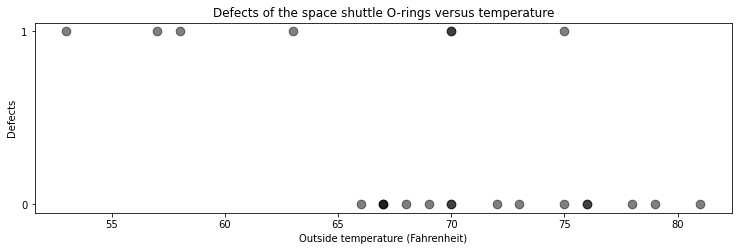

In [4]:
plt.figure(figsize=(12.5, 3.5))
plt.scatter(challenger_data.iloc[:, 0], challenger_data.iloc[:, 1], s=75,
 color="k", alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Defects")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the space shuttle O-rings versus temperature");
plt.savefig("wholedataset.pdf")

The purpose of this Notebook is to quantify the influence of the temperature in the probability of having an incident related to the O-rings failure. Specifically, our goal is to address the following questions:

* Is the temperature associated with O-ring incidents?
* How was the temperature affecting the probability of O-ring incidents?
* What was the predicted probability of an incident in an O-ring for the temperature of the launch day?

The independent variable in this case is
* temperature (continuous)

The dependent variable is 
* failure (**categorical**)

Therefore, this is a classification problem (it is not a regression problem).
Given a value of the temperature we want to classify O-rings according to two classes:
1. O-ring will fail
2. O-ring won't fail

More specifically, we want to determine the probability of the two classes:
* p(O-ring will fail),  p(O-ring won't fail)=1-p(O-ring will fail)

## References
Dalal, Siddhartha R., Edward B. Fowlkes, and Bruce Hoadley. "Risk analysis of the space shuttle: Pre-Challenger prediction of failure." Journal of the American Statistical Association 84.408 (1989): 945-957

This notebook uses material from:
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers
chapter 2.

### What you will learn in this Notebook
1. to address the Chellenger disaster
2. to build a logistic regression model
3. to train a logistic regression model using the general ML recipe
4. to build a Bayesian logistic regression model
5. to use it to compute probabilities and probability of probabilities
6. to evaluate the risk of a decision in a classification problem
7. to understand the basic idea behind Generalised Linear Models.

## Analysis

From the data, it is apparent that the probability of damage incidents occurring increases as the outside temperature decreases. We aim to model the probability of damage as a function of the temperature. 

Our model is therefore a function of temperature that is bounded between 0 and 1 (because it has to model a probability) and changes from 1 to 0 as we increase temperature. There are actually many such functions, but the most popular choice is the logistic function.

$$
\Phi(t)= \dfrac{1}{1+e^{-t}}
$$


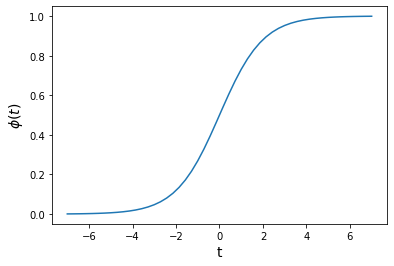

In [5]:
t = np.linspace(-7,7,50)
plt.plot(t,1/(1+np.exp(-t)))
plt.xlabel("t",fontsize=14)
plt.ylabel("$\phi(t)$",fontsize=14)
plt.savefig("logistic.pdf")

We introduce a slope ($\beta$) and shift ($\alpha$) parameter
to add flexibility to this model

$$
\Phi(\alpha+\beta\,t)= \dfrac{1}{1+e^{\beta\,t+\alpha}}
$$


Note that if 
* $\Phi(\alpha+\beta\,t)$ is the probability of damage then
* $1-\Phi(\alpha+\beta\,t)$ is the probability of no damage

We can rewrite the above if as

$$
p(y|t,\alpha,\beta)=\Phi(\alpha+\beta\,t)^{y}(1-\Phi(\alpha+\beta\,t))^{1-y}  \text{ for } y=0,1
$$

note in fact that when $y=0$ one gets $(1-\Phi(\alpha+\beta\,t))$ and when $y=1$ one gets $\Phi(\alpha+\beta\,t)$. This likelihood is a *Bernoulli distribution*.

We have N=23 observations in our dataset. If we assume the observations are independent then

$$
\begin{aligned}
p(\mathcal{D}|\alpha,\beta):=p(y_1,\dots,y_N|t_1,\dots,t_N,\alpha,\beta)
&=\prod_{(t_i,y_i)\in\mathcal{D}}\Phi(\alpha+\beta\,t)^{y_i}(1-\Phi(\alpha+\beta\,t))^{1-y_i}
\end{aligned}
$$
this is the likelihood of the data given the parameters $\alpha,\beta$.

## Maximum Likelihood Estimator
We do not know $\theta=[\alpha,\beta]$ we can learn them from data by using the general ML recipe
That is we perform maximum likelihood estimation:

* MLE:

$$
\max_{\alpha,\beta} \prod_{(t_i,y_i)\in\mathcal{D}}\Phi(\alpha+\beta\,t_i)^{y_i}(1-\Phi(\alpha+\beta\,t_i))^{1-y_i}
$$

where $(t_i,y_i)$ denotes the i-th observations in the dataset: temperature and class variable

No closed-form solution exists, we must use a numerical optimisation method.
Instead of optimising it directly we will use the implementation of this model in `sklearn`.
This model is called "Logistic Regression" (even if it is a classifier).


In [184]:
#we standandardise data for numerical stability
mean = np.mean(challenger_data.iloc[:,0].values)
std = np.std(challenger_data.iloc[:,0].values)
t = (challenger_data.iloc[:,0].values-mean)/std#standard scaler
y = challenger_data.iloc[:,1].values
X = t.reshape(-1,1)
#we have added the column of ones to include the intercept 
from sklearn.linear_model import LogisticRegression
#fit the model (learning)
clf = LogisticRegression(solver='lbfgs',C=900).fit(X, y)#we remove the reguralisation
#'lbfgs' is the name of the optimizer we use to solve the MLE optimisation problem


In [178]:
#parameters estimated by Sklearn LogisticRegression
print(clf.intercept_,clf.coef_)

[-1.107] [[-1.601]]


Given the parameters we can compute the predicted probability as follows

In [179]:
tpred=(50-mean)/std
#probability class 1
print(1/(np.exp(-clf.intercept_-clf.coef_*tpred)+1))
#using sklearn command probability [class 0, class 1]
print(clf.predict_proba(np.array([[tpred]])))

[[0.969]]
[[0.031 0.969]]


the predicted class is the class with the highest probability

In [180]:
print(np.round(1/(np.exp(-clf.intercept_-clf.coef_*tpred)+1)))
#predicted class
print(clf.predict(np.array([[tpred]])))

[[1.]]
[1.]


We now predict for the temperature of the day of the distaster 31F

In [181]:
xpred = (np.array([[31]])-mean)/std#standard scaler
#class prediction 
cl = clf.predict(xpred) 
#probability of class prediction 
pa = clf.predict_proba(xpred) 
print("Class="+str(cl)+" Probability class="+str(pa))

Class=[1.] Probability class=[[0. 1.]]


It tells us that the class is $1$, that is the O-ring will fail.
The model is absolutely certain about that. **The disaster could be avoided.** We can plot
`pa` for different values of t

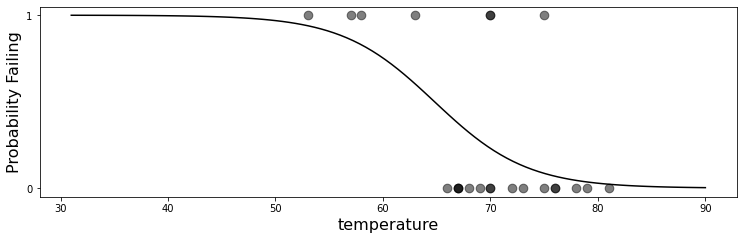

In [183]:
tpred= np.linspace(31,90,100)
Xpred = (tpred.reshape(-1,1)-mean)/std#standard scaler
plt.figure(figsize=(12.5, 3.5))
plt.plot(tpred,clf.predict_proba(Xpred)[:,1], color="k")
plt.xlabel("temperature",fontsize=16);
plt.ylabel("Probability Failing",fontsize=16,rotation=90)

plt.scatter(challenger_data.iloc[:, 0], challenger_data.iloc[:, 1], s=75,
 color="k", alpha=0.5)
plt.yticks([0, 1]);

For instance, at 86F, the probability of failure is


In [172]:
xpred = np.array([[86]])
#class prediction 
cl = clf.predict(xpred) 
#probability of class prediction 
pa = clf.predict_proba(xpred)[:,1]
print("Class="+str(cl)+" Probability class="+str(pa))

Class=[0.] Probability class=[0.007]


### IMPORTANT
 In a classification problem, the logistic classifier gives you a probability value for each class, but this is not the same as uncertainty we compute in probabilistic Machine Learning. This probability is the probability that an input is a given class relative to the other classes. Because the probability is relative to the other classes, it does not help explain the model's overall confidence on its own predictions.
 In other words, the probability of class $1$ can be 0.9, but the model may still be very uncertain.
 Of course, `sklearn` logistic regression does not give us any measure of uncertainty and, therefore, we cannot know that but we can move to probabilistic (Bayesian) Machine Learning.
 
 Why uncertainty is important?
 
 Consider these two cases:
 1. the estimated probability of class 1 (failure) is 0.999, and the model is very certain about that
 2.  the estimated  probability of class 1 (failure) is 0.999, and the model is uncertain about that, that is there is a *non-small chance* that the true probability  is actually 0.97.
 
 In case 2, we cannot exclude that the probability of a disaster is 3%, which is huge when there are either human lives at stake (like in the Challenger disaster or automatic car) or a lot of money involved (automatic trading in finance).
 
 These are the reasons we need to model and consider uncertainty in decision making.
  

### Bayesian model
We know repeat the analysis using probabilistic ML. We have defined the likelihood and, therefore, to complete the probabilistic model we must define the prior distribution on
$\alpha,\beta$, $p(\alpha,\beta)$, and then compute the posterior

$$
p(\alpha,\beta|\mathcal{D})=\dfrac{p(\mathcal{D}|\alpha,\beta)p(\alpha,\beta)}{
    \int p(\mathcal{D}|\alpha,\beta)p(\alpha,\beta)d\alpha d\beta
}
$$

In this case, the posterior does not have closed-form.
We must compute the posterior distribution using a numerical method. We will implement the following probabilistic model.


**Likelihood**

$$
p(y_i|\alpha,\beta,\sigma,t_i)=\Phi(\alpha+\beta\,t_i)^{y_i}(1-\Phi(\alpha+\beta\,t_i))^{1-y_i}
$$

that is $p(y_i=1|\alpha,\beta,\sigma,t_i)=\Phi(\alpha+\beta\,t_i)$ and $p(y_i=0|\alpha,\beta,\sigma,t_i)=(1-\Phi(\alpha+\beta\,t_i))$.


Therefore, assuming the observations are independent

$$
\begin{aligned}
p(data|\alpha,\beta):=p(y_1,\dots,y_N|t_1,\dots,t_N,\alpha,\beta)
&=\prod_{(t_i,y_i)\in\mathcal{D}}\Phi(\alpha+\beta\,t)^{y_i}(1-\Phi(\alpha+\beta\,t))^{1-y_i}
\end{aligned}
$$


**Prior**
$$
p(\alpha)=N(\alpha,0,30), ~~p(\beta)=N(\beta,0,30)
$$

**Posterior** 
You have to use PyMC3 to sample from the posterior define by the above model, that is

$$
\underbrace{p(\alpha,\beta|\text{data})}_{\text{posterior}} = \frac{\underbrace{\prod_{i=1}^{n}\Phi(\alpha+\beta\,t_i)^{y_i}(1-\Phi(\alpha+\beta\,t_i))^{1-y_i}}_{\text{likelihood}}\underbrace{N(\alpha,0,30)N(\beta,0,30)}_{\text{prior}}}{\underbrace{p(\text{data})}_{\text{evidence}}}
$$

We set up this model in PyMC3, which computes for us samples from $p(\alpha,\beta|\text{data})$ that we can use for decision making.


In [185]:
#we standandardise data for numerical stability
mean = np.mean(challenger_data.iloc[:,0].values)
std = np.std(challenger_data.iloc[:,0].values)
t = (challenger_data.iloc[:,0].values-mean)/std
y = challenger_data.iloc[:,1].values
X = np.hstack([np.ones((len(t),1)),t.reshape(-1,1)])

with pm.Model() as logistic_model:        
    theta = pm.Normal('theta', 0.0, sd=30, shape=(2,)) #theta=[alpha,beta]
    phi = pm.Deterministic('phi', pm.math.invlogit(pm.math.dot(X, theta)))#logistic function 
    #tt.printing.Print('alpha_ls')(phi)
    likelihood = pm.Bernoulli('likelihood', phi, observed=y)

I go through the above model line-by-line:

`theta = pm.Normal('theta', 0.0, sd=30, shape=(2,)) #theta=[alpha,beta]
 phi = pm.Deterministic('phi', pm.math.invlogit(pm.math.dot(X, theta)))#logistic function 
`

is an equivalent way to write 

`alpha = pm.Normal('alpha', 0.0, sd=30) 
 beta = pm.Normal('beta', 0.0, sd=30) 
 mu =alpha + t*beta
 phi = pm.Deterministic('phi', pm.math.invlogit(mu))#logistic function 
 likelihood = pm.Bernoulli('likelihood', phi, observed=y)
`

basically the first three lines define a **linear regression** model and then we squeeze it through
 the sigmoid function `pm.math.invlogit` (logistic function) and use phi as the probability of class 1. Therefore, the probability of observing all the classes in $y$ is defined by a Bernoulli distribution

$$
\Phi(\alpha+\beta\,t)^{\text{#observations class 1}}(1-\Phi(\alpha+\beta\,t))^{\text{#observations class 0}}
$$

In [207]:
with logistic_model:
    posterior = pm.sample(5000, tune=3000,chains=1)#we can compute the posterior samples now

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]
Sampling chain 0, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2528.09it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


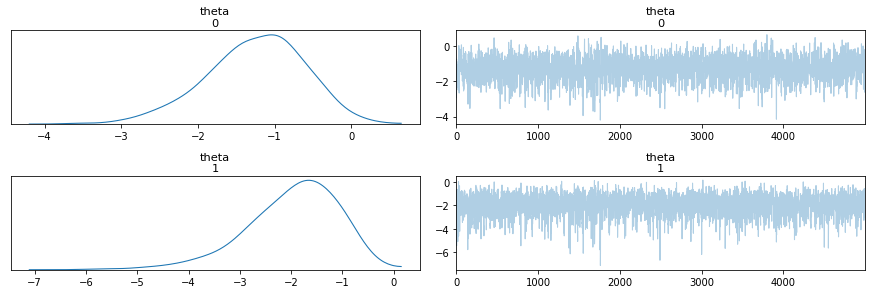

In [208]:
pm.plot_trace(posterior, var_names=['theta']);

the density plots of $\theta_0.\theta_1$ are the posterior density of intercept and slope.

In [209]:
posterior['theta'][0:5,:]#these are 5 samples from the posterior of theta_0 (first colum) and theta_1 (2nd col)

array([[-1.335, -2.447],
       [-1.552, -3.094],
       [-2.777, -4.862],
       [-2.591, -5.019],
       [-2.936, -4.762]])

Each sample in `posterior[theta]` defines a logistic classifier. The fact that the rows do not coincide is due to uncertainty on the estimate of $\alpha,\beta$ and we can plot the uncertainty as follows.

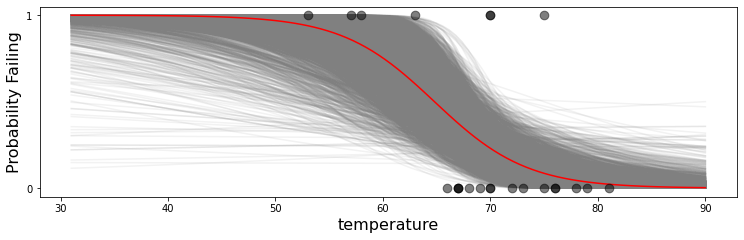

In [210]:
plt.figure(figsize=(12.5, 3.5))
tpred= np.linspace(31,90,100)
plt.xlabel("temperature",fontsize=16);
plt.ylabel("Probability Failing",fontsize=16,rotation=90)
plt.scatter(challenger_data.iloc[:, 0], challenger_data.iloc[:, 1], s=75,
 color="k", alpha=0.5, Zorder=100)
plt.yticks([0, 1]);

scaled_temp = (tpred[:,np.newaxis]-mean)/std#standard scaling
lines=1/(1+np.exp(-posterior['theta'][:,0] - posterior['theta'][:,1] * scaled_temp))
plt.plot(tpred, lines , c='gray', alpha=0.1);

#compare to sklearn
plt.plot(tpred.reshape(-1,1),clf.predict_proba((tpred.reshape(-1,1)-mean)/std)[:,1], color="red");

The grey lines represent classifier obtained using different samples from the posterior. The red line is the `sklearn` classifier. The envelope of the grey lines is a visual representation of the uncertainty. For instance note that the model is particularly uncertainty at the temperature t=60, this can be seen from the fact that the grey lines are more far apart at t=60, while it is is less uncertain around t=90 or around t=30 (for instance).

This "uncertainty" represents the uncertainty of the classifier on the estimated probability of class $1$. As I wrote before, note that for t=50 (for instance) the red line (`sklearn` classifier) is greater than  0.9 (that is the probability of class 1 is close to 1), but there is a lot of uncertainty as shown by the Bayesian classifier. This is expected considering the small unbalanced dataset, but the MLE approach (`sklearn`) is not able to **express** this uncertainty (we will clarify in the next notebook that `sklearn` actually computes a MAP estimate due to the reguralisation term $C$, but when $C$ is large MAP coincides with MLE).

The general recipe logistic classifier implemented in `sklearn` can only return a point estimate of intercept and slope, instead Bayesian logistic regression returns a posterior distribution (the samples of intercept and slope). A way to summarise these sample is to compute the
* mean
* credible intervals

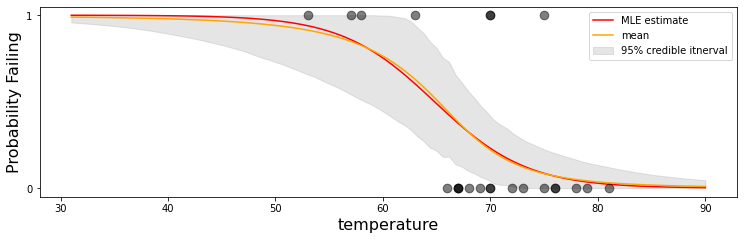

In [247]:
plt.figure(figsize=(12.5, 3.5))
tpred= np.linspace(31,90,100)
plt.xlabel("temperature",fontsize=16);
plt.ylabel("Probability Failing",fontsize=16,rotation=90)
plt.scatter(challenger_data.iloc[:, 0], challenger_data.iloc[:, 1], s=75,
 color="k", alpha=0.5, Zorder=100)
plt.yticks([0, 1]);

scaled_temp = (tpred[:,np.newaxis]-mean)/std#standard scaling
lines=1/(1+np.exp(-posterior['theta'][:,0] - posterior['theta'][:,1] * scaled_temp))

#compare to sklearn
plt.plot(tpred.reshape(-1,1),clf.predict_proba((tpred.reshape(-1,1)-mean)/std)[:,1], color="red",label='MLE estimate');

#posterior mean of the lines
plt.plot(tpred, np.mean(lines,axis=1), c='orange', label='mean')
credib_interval=pm.hpd(lines.T,credible_interval=0.95)
plt.fill_between(tpred,credib_interval[:,0],credib_interval[:,1],alpha=0.2,color='gray',label='95% credible itnerval')
plt.legend()

The orange line is the mean of all the gray lines we plotted before, and the gray area is the smallest region
that includes the 95% of the gray lines. 

Let us better understand the difference between the red lines and the orange line. They are close but they do not coincide. Why?

First we analyse the difference between the parameters estimated via "MLE" (Sklearn) and the posterior $p(\alpha,\beta|\text{data})$. We will summarise $p(\alpha,\beta|\text{data})$ with a point estimate, the posterior mean and compare the difference with MLE.

In [249]:
print("Pymc3 posterior mean of the parameters")
posterior_mean=np.mean(posterior['theta'],axis=0)
print(posterior_mean)
print("Sklearn general recipe logistic regression")
print(clf.intercept_, clf.coef_[0,:])

Pymc3 posterior mean of the parameters
[-1.259 -1.981]
Sklearn general recipe logistic regression
[-1.107] [-1.601]


SKlearn returns approximatively  the maximum of the posterior. As shown below, the posterior mean
can be different from the maximum when the posterior is not symmetric (**skewed**). The posterior mean is a better point estimate of the maximum because it accounts of the uncertainty.
In logistic regression, the posterior is skewed and, therefore, the point estimate returned by `sklearn` is too optimistic.

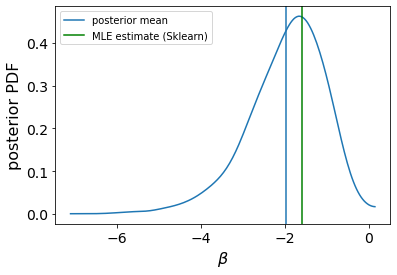

In [250]:
az.plot_dist(posterior['theta'][:,1])
plt.xlabel("$\\beta$", fontsize=16)
plt.ylabel("posterior PDF", fontsize=16)
plt.axvline(posterior_mean[1],label='posterior mean')
plt.axvline(clf.coef_[0,:],label='MLE estimate (Sklearn)',color='g')
plt.legend()

In [ ]:
We can now quantify the uncertainty about the prediction at t=31 (temperature at the launch)


95% HPD= [0.969 1.   ]


Text(0.5, 0, 'Posterior')

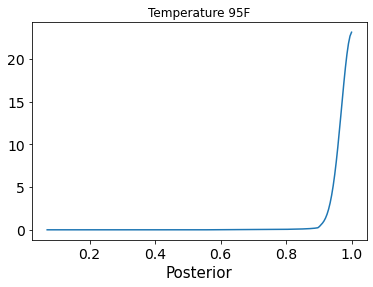

In [58]:
## prediction at 31F

tpred = np.array([[31]])

az.plot_dist((1/(1+np.exp(-posterior['theta'][:,0] - posterior['theta'][:,1] *(tpred-mean)/std)))[0,:]) #,credible_interval=0.95, ref_val=0.05);
print("95% HPD=",pm.hpd((1/(1+np.exp(-posterior['theta'][:,0] - posterior['theta'][:,1] *(tpred-mean)/std)))[0,:]))
plt.title("Temperature 95F")
plt.xlabel("p(failure)",fontsize=15)
plt.xlabel("Posterior",fontsize=15)
#plt.savefig("plot95_mt.pdf")

It tells us that the class is $1$, that is the O-ring will fail.
The probabilistic model is also certain about that. The 95% HPD (that is the smallest interval that includes the 95% of the probability) is [0.97,1]. **The disaster could be avoided.** 
Data weren't inconclusive.

The above plot  is a probability over the probability $\phi(t,\alpha,\beta)$ . It tells us our uncertainty
about the estimate of this probability and can be used for risk analysis. Consider now a temperature of 90F.

95% HPD= [0.    0.036]


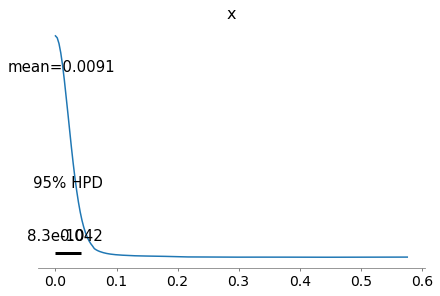

In [62]:
## prediction at 90F

tpred = np.array([[90]])
az.plot_posterior((1/(1+np.exp(-posterior['theta'][:,0] - posterior['theta'][:,1] *(tpred-mean)/std)))[0,:],credible_interval=0.95);
print("95% HPD=",pm.hpd((1/(1+np.exp(-posterior['theta'][:,0] - posterior['theta'][:,1] *(tpred-mean)/std)))[0,:]))

In this case, it tells us that although the mean probability is basically zero (0.009), the 95% HPD includes
values higher than 1%. This means that the risk of a disaster is not negligible.

The general ML recipe (based on MLE or, equivalently, loss minimisation) does not provide us
this second order information that is fundamental in decision making.

**Probabilistic model allows us to evaluate the risk of a decision in a classification problem!**

This uncertainty is due to the fact that the number of observations is quite low N=23 and, therefore,
we could collect more data to reduce this uncertainty.

Bayesian analysis tells us also where we should collect the data first, that is very the uncertainty is higher
(around 65F where the uncertainty is higher).

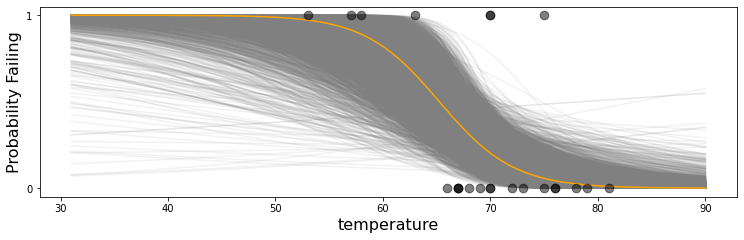

In [63]:
tpred= np.linspace(31,90,100)
plt.figure(figsize=(12.5, 3.5))
plt.xlabel("temperature",fontsize=16);
plt.ylabel("Probability Failing",fontsize=16,rotation=90)
plt.scatter(challenger_data.iloc[:, 0], challenger_data.iloc[:, 1], s=75,
 color="k", alpha=0.5, Zorder=100)
plt.yticks([0, 1]);

alpha_m = posterior['theta'][:,0].mean(axis=0)
beta_m = posterior['theta'][:,1].mean(axis=0)
plt.plot(tpred, 1/(1+np.exp(-posterior['theta'][:,0] - posterior['theta'][:,1] *(tpred[:,np.newaxis]-mean)/std)), c='gray', alpha=0.1);

plt.plot(tpred, 1/(1+np.exp(-alpha_m - beta_m *(tpred[:,np.newaxis]-mean)/std)), c='orange', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))


## Correct way to compute posterior expectations

There is also another important aspect to stress. When we compute the mean predicted probability, we should apply the logistic function to each sample and then compute the mean. Instead it is wrong to compute the mean of the parameters first and then apply the logistic function.


In [253]:
temp_pred=np.array([[62]])
scaled_temp = (temp_pred-mean)/std#standard scaling
proba1=1/(1+np.exp(-posterior['theta'][:,0] - posterior['theta'][:,1] * scaled_temp))
print("correct mean predicted probability", np.mean(proba1,axis=1))
proba2=1/(1+np.exp(-np.mean(posterior['theta'][:,0]) - np.mean(posterior['theta'][:,1]) * scaled_temp))
print("wrong mean predicted probability",np.mean(proba2,axis=1))

correct mean predicted probability [0.68]
wrong mean predicted probability [0.713]


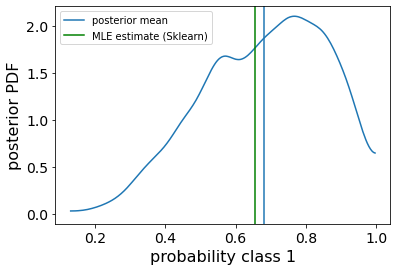

In [254]:
az.plot_dist(proba1)
plt.xlabel("probability class 1", fontsize=16)
plt.ylabel("posterior PDF", fontsize=16)
plt.axvline( np.mean(proba1,axis=1),label='posterior mean')
plt.axvline(clf.predict_proba(scaled_temp)[:,1],label='MLE estimate (Sklearn)',color='g')
plt.legend()

Why is the case? Because the expected value with respect of $x$ of a nonlinear function $f$ of $x$ is
different from $f$ applied to the expectation of $x$, that is

$$
E[f(x)] \neq f(E[x])
$$

whenever $f$ is a nonlinear function. Let's see it with another example

In [256]:
import scipy.stats as st
z=st.norm().rvs(10000)
print(np.mean(z**2), "is different from ", np.mean(z)**2)

1.005686760569191 is different from  3.385204947982173e-05


In logistic classifier we want to compue the mean predicted probability, that is

$$
E[\Phi(\alpha+\beta t)]
$$

which is different from

$$
\Phi(E[\alpha]+E[\beta] t)
$$


## Other way of writing a Bayesian logistic regression model
There is another way we can write this model by replacing the logistic function


$$
\Phi(\alpha+\beta\,t)= \dfrac{1}{1+e^{\beta\,t+\alpha}}
$$

with the CDF of the normal distribituion as we have done for interval analysis. The above function can be approximate using the normal CDF:

$$
\Phi\left(\frac{\pi}{8}(\alpha+\beta\,t)\right)= \int_{-\infty}^{\frac{\pi}{8}(\alpha+\beta\,t)} \dfrac{1}{\sqrt{2 \pi}} e^{-x^2/2} dx
$$

the constant $\frac{\pi}{8}$ ensures that the two sigmoid functions coincide.


In [103]:
#we standandardise data for numerical stability
mean = np.mean(challenger_data.iloc[:,0].values)
std = np.std(challenger_data.iloc[:,0].values)
t = (challenger_data.iloc[:,0].values-mean)/std
y = challenger_data.iloc[:,1].values
X = np.hstack([np.ones((len(t),1)),t.reshape(-1,1)])

import theano.tensor as tt

y
with pm.Model() as logistic_model:        
    theta = pm.Normal('theta', 0.0, sd=30, shape=(2,)) #theta=[alpha,beta]
    mu=pm.math.dot(X, theta)
    phi = pm.Deterministic('phi',  0.5*(1+tt.erf(mu*np.sqrt(np.pi/8)/np.sqrt(2))))#logistic function 
    #tt.printing.Print('alpha_ls')(phi)
    likelihood = pm.Bernoulli('likelihood', phi, observed=y)

with logistic_model:
    posterior = pm.sample(5000, tune=3000,chains=1)#we can compute the posterior samples now

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.gof.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_inplace}.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/benavoli/.local/lib/python3.6/site-packages/theano/gof/opt.py", line 2034, in process_node
    replacements = lopt.transform(node)
  File "/home/benavoli/.local/lib/python3.6/site-packages/theano/tensor/opt.py", line 6789, in local_grad_log_erfc_neg
    if not exp.owner.inputs[0].owner:
AttributeError: 'NoneType' object has no attribute 'owner'

Sequential sampling (1 chains in 1 job)
NUTS: [theta]
Sampling chain 0, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2746.90it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


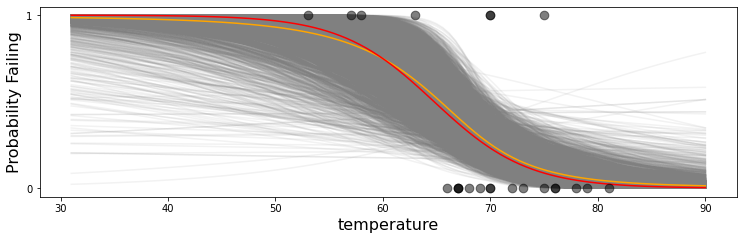

In [102]:
plt.figure(figsize=(12.5, 3.5))
tpred= np.linspace(31,90,100)
plt.xlabel("temperature",fontsize=16);
plt.ylabel("Probability Failing",fontsize=16,rotation=90)
plt.scatter(challenger_data.iloc[:, 0], challenger_data.iloc[:, 1], s=75,
 color="k", alpha=0.5, Zorder=100)
plt.yticks([0, 1]);

lines=1/(1+np.exp(-posterior['theta'][:,0] - posterior['theta'][:,1] *(tpred[:,np.newaxis]-mean)/std))
plt.plot(tpred, lines , c='gray', alpha=0.1);


#this is wrong
plt.plot(tpred, np.mean(lines,axis=1), c='orange', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))



Xpred = np.hstack([np.ones((len(tpred),1)),tpred.reshape(-1,1)])
plt.plot(Xpred[:,1],clf.predict_proba(Xpred)[:,1], color="red")

## Generalised Linear Model (optional)
The same idea we used in logistic regression, namely transforming the linear model

$$
\theta_0+\theta_1 x_1 + \dots +\theta_m x_m
$$

where I have assumed we have $m$ inputs, through a nonlinear function, $\phi(\theta_0+\theta_1 x_1 + \dots +\theta_m x_m)$,  to match the variable type can be generalised. This raises the family of generalized linear models, which extends the linear model to different kinds of output variables and provides a convenient parametric framework.

In [71]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('Damage_Incident ~ Temp',
                            challenger_data,
                            family=pm.glm.families.Binomial())
    trace = pm.sample(500, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Temp, Intercept]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1594.27draws/s]
The acceptance probability does not match the target. It is 0.8941333448336555, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6404001325799156, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


The link function is selected based on the likelihood (in the example above it will be a logistic). In this case the model doesn't converge because we haven't normalised the temperature.

## GLM regression (optional)
I recommend you to give a look to these notebooks

https://docs.pymc.io/notebooks/GLM-poisson-regression.html

https://docs.pymc.io/notebooks/GLM-robust.html